# การทดลองที่2 : การทดลองปรับค่าพารามิเตอร์เพื่อสร้างโมเดลการทำนายค่าแบบต่างๆ และเปรียบเทียบประสิทธิภาพของโมเดลทดสอบ

# ตอนที่1: การทดลองเตรียมข้อมูล ปรับค่าข้อมูล และจัดแบ่งชุด Train, Test เพื่อสอนโมเดล

## 1.1 เตรียมข้อมูลทดลอง

In [1]:
# Stock data
import quandl
import datetime

# Analyzing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

In [2]:
stock_MSFT = pd.read_csv('MSFT.csv')
stock_MSFT.set_index('Date', inplace=True)

# stock_MSFT = quandl.get("WIKI/AMZN")
# stock_MSFT.to_csv('MSFT.csv')
# stock_MSFT.index = pd.to_datetime(stock_MSFT.index)
stock_MSFT

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1997-05-16,22.38,23.75,20.50,20.75,1225000.0,0.0,1.0,1.865000,1.979167,1.708333,1.729167,14700000.0
1997-05-19,20.50,21.25,19.50,20.50,508900.0,0.0,1.0,1.708333,1.770833,1.625000,1.708333,6106800.0
1997-05-20,20.75,21.00,19.63,19.63,455600.0,0.0,1.0,1.729167,1.750000,1.635833,1.635833,5467200.0
1997-05-21,19.25,19.75,16.50,17.13,1571100.0,0.0,1.0,1.604167,1.645833,1.375000,1.427500,18853200.0
1997-05-22,17.25,17.38,15.75,16.75,981400.0,0.0,1.0,1.437500,1.448333,1.312500,1.395833,11776800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,1586.45,1590.00,1563.17,1581.86,4667291.0,0.0,1.0,1586.450000,1590.000000,1563.170000,1581.860000,4667291.0
2018-03-22,1565.47,1573.85,1542.40,1544.10,6177737.0,0.0,1.0,1565.470000,1573.850000,1542.400000,1544.100000,6177737.0
2018-03-23,1539.01,1549.02,1495.36,1495.56,7843966.0,0.0,1.0,1539.010000,1549.020000,1495.360000,1495.560000,7843966.0


## 1.2 ปรับรูปแบบของข้อมูล 

In [3]:
# สร้างข้อมูลทางเลือกด้วยการทำ Normalization ข้อมูล ‘Close’ ที่เลือก
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
stock_MSFT['Close_norm'] = scaler.fit_transform(np.array(stock_MSFT['Close']).reshape(-1, 1))
stock_MSFT_Close = pd.DataFrame(stock_MSFT['Close_norm'])

# สร้างข้อมูลราคาวันถัดไป Next_N-day เพื่อใช้เป็นคำตอบ (Ground Truth) ในการคาดการณ์
Next_N_day = 30
GT = stock_MSFT_Close.iloc[Next_N_day :]
stock_MSFT = stock_MSFT_Close.iloc[:-Next_N_day]
stock_MSFT = stock_MSFT.assign(GT=GT.values)
stock_MSFT

,Close_norm,GT
Date,,
1997-05-16,0.009281,0.007869
1997-05-19,0.009124,0.007674
1997-05-20,0.008578,0.008220
1997-05-21,0.007008,0.010657
1997-05-22,0.006770,0.011322
...,...,...
2018-02-06,0.902318,0.989620
2018-02-07,0.885953,0.965907
2018-02-08,0.844312,0.935425


## 1.3 จัดเตรียมข้อมูลสำหรับ train validation และ test


In [4]:
# ข้อมูล test ให้ใช้ข้อมูล ‘GT’ ช่วง 60 วันท้าย
test_df = stock_MSFT.iloc[len(stock_MSFT) - 60:]
X_test = np.array(test_df.Close_norm).reshape(-1, 1)
y_test = test_df.GT

# # เตรียมข้อมูล train, validate
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    np.array(stock_MSFT.Close_norm[:-60]).reshape(-1, 1),
    stock_MSFT.GT[:-60],
    test_size=0.2, random_state=42,
    shuffle=True)

## 1.4 แสดงรูปกราฟการกระจายของ train validate ที่แบ่งจากข้อ 1.3

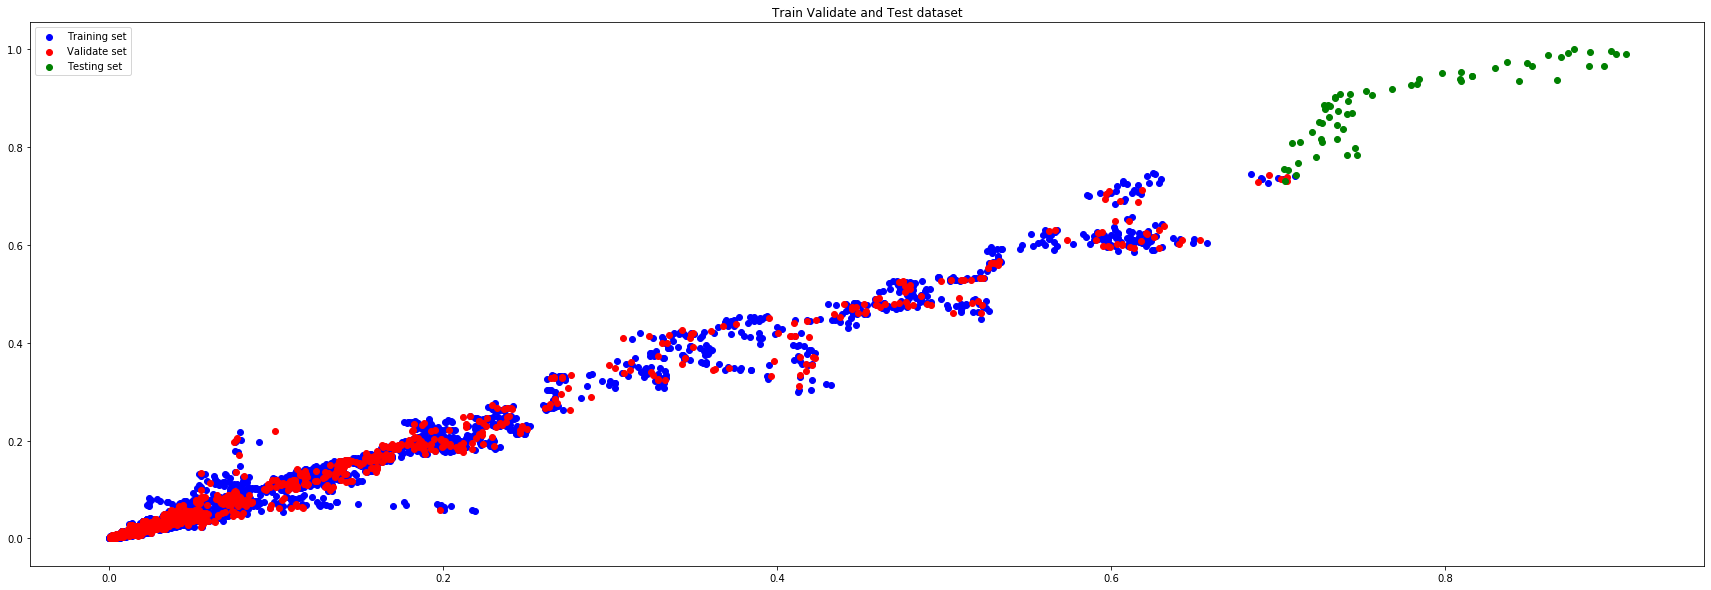

In [5]:
# ตั้งค่าขนาดพื้นที่ภาพ
plt.figure(figsize=(30,10))

# scatter plot ความสัมพันธ์ของค่า X_train, y_train 
plt.scatter(X_train, y_train, marker='o', color='blue', label='Training set')
plt.scatter(X_valid, y_valid, marker='o', color='red', label='Validate set')
plt.scatter(X_test, y_test, marker='o', color='green', label='Testing set')
plt.title('Train Validate and Test dataset')
plt.legend()
plt.show()

# ตอนที่ 2: การทดลองทำ Cross validation และ prediction เพื่อดูค่าความแม่นยำของแต่ละโมเดล

## 2.1 ทำการทดสอบพารามิเตอร์สำหรับโมเดลด้วยการทำ Cross Validation


In [6]:
from sklearn.model_selection import KFold, cross_val_score

# สร้างโมเดลรูปแบบ cross validation ที่ต้องการใช้ ในที่นี้ใช้ K-Fold โดยใช้ฟังก์ชัน
kf = KFold(n_splits=10, random_state=2011, shuffle=True)

# สร้าง prediction model พร้อมระบุพารามิเตอร์ที่ต้องการ
# Linear Regression Model
LRM = LinearRegression()

# Support Vector Regression (SVR) Model จำนวน 3 รูปแบบ kernel
c_val = 1000                   # ค่าปรับเข้มงวดกับ outlier bound [10^-6, 10^6] ค่าที่น่าสนใจ 1000
gramma_value = 0.1              # ค่าการควบคุมรูปร่างของโมเดล [10^-6, 10^6] ค่าน่าสนใจ 0.1
svr_lin = SVR(kernel='linear', C=c_val)
svr_rbf = SVR(kernel='rbf', C=c_val, gamma=gramma_value)
svr_poly = SVR(kernel='poly', C=c_val, degree=2)

# ทำ cross validation สำหรับแต่ละโมเดล model_name
LRM_cross = cross_val_score(LRM, X_train, y_train, cv=kf)
print('LRM ', LRM_cross)

svr_lin_cross = cross_val_score(svr_lin, X_train, y_train, cv=kf)
print('svr_lin_cross ', svr_lin_cross)

svr_rbf_cross = cross_val_score(svr_rbf, X_train, y_train, cv=kf)
print('svr_rbf_cross ', svr_rbf_cross)

svr_poly_cross = cross_val_score(svr_poly, X_train, y_train, cv=kf)
print('svr_poly_cross ', svr_poly_cross)

LRM  [0.98678326 0.98483287 0.98380469 0.98420487 0.97614466 0.98251399
 0.98209018 0.97367528 0.98038936 0.98595145]
svr_lin_cross  [0.96782442 0.97062551 0.94664382 0.95884304 0.97166824 0.95047973
 0.95369742 0.94041886 0.97826433 0.96359921]
svr_rbf_cross  [0.94033043 0.92694502 0.96694975 0.95486879 0.93248888 0.9353897
 0.92221481 0.90072679 0.93233432 0.94664992]


C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

svr_poly_cross  [0.82932203 0.79136776 0.79965126 0.81086436 0.81289912 0.81097595
 0.78362361 0.73039945 0.81259368 0.85537503]


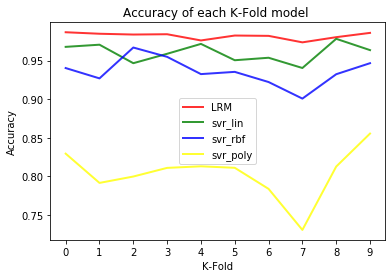

In [7]:
# แสดงรูปกราฟเปรียบเทียบ score ที่ได้จากโมเดลทั้ง 4 แบบที่คำนวณข้างบน

from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(np.arange(len(LRM_cross)), LRM_cross, color='red', alpha=0.8, lw=2)
ax.plot(np.arange(len(LRM_cross)), svr_lin_cross , color='green', alpha=0.8, lw=2)
ax.plot(np.arange(len(LRM_cross)), svr_rbf_cross , color='blue', alpha=0.8, lw=2)
ax.plot(np.arange(len(LRM_cross)), svr_poly_cross , color='yellow', alpha=0.8, lw=2)

ax.legend(['LRM', 'svr_lin', 'svr_rbf', 'svr_poly'])
ax.set_xlabel('K-Fold')
ax.set_ylabel('Accuracy')
plt.title('Accuracy of each K-Fold model ')
plt.show()

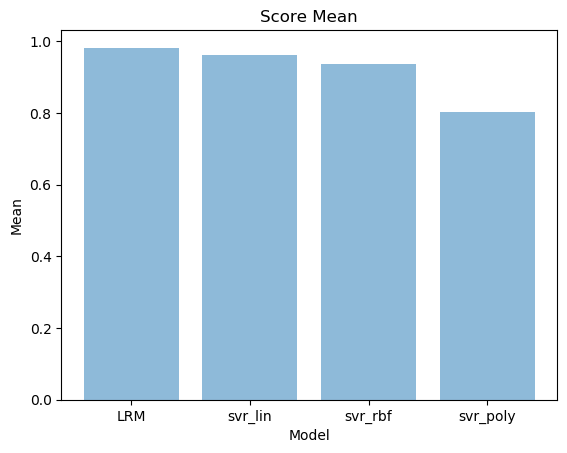

In [8]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_cross.mean(), svr_lin_cross.mean(), svr_rbf_cross.mean(), svr_poly_cross.mean()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Model')
plt.title('Score Mean')

plt.show()

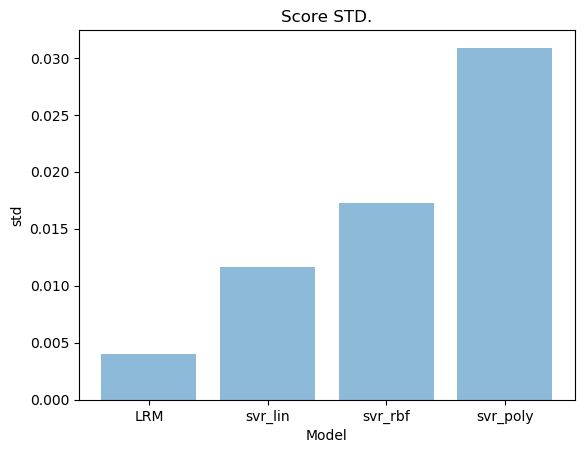

In [9]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_cross.std(), svr_lin_cross.std(), svr_rbf_cross.std(), svr_poly_cross.std()]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('std')
plt.xlabel('Model')
plt.title('Score STD.')

plt.show()

## 2.2 ทดสอบโมเดลทั้ง 4 แบบ ที่กำหนดพารามิเตอร์ไว้ในข้อ 2.1

In [10]:
# ทำการ train โมเดลทั้ง 4 แบบ ด้วยข้อมูล Train ที่แบ่งไว้
LRM.fit(X_train, y_train)
svr_lin.fit(X_train, y_train)
svr_rbf.fit(X_train, y_train)
svr_poly.fit(X_train, y_train)

C:\Users\ruji-\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1000, cache_size=200, coef0=0.0, degree=2, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
# ทำการ predict ข้อมูลชุด Validation และ Test
LRM_pred_valid = LRM.predict(X_valid)
LRM_pred_test  = LRM.predict(X_test)

svr_lin_pred_valid = svr_lin.predict(X_valid)
svr_lin_pred_test = svr_lin.predict(X_test)

svr_rbf_pred_valid = svr_rbf.predict(X_valid)
svr_rbf_pred_test = svr_rbf.predict(X_test)

svr_poly_pred_valid = svr_poly.predict(X_valid)
svr_poly_pred_test = svr_poly.predict(X_test)

In [12]:
# คำนวณค่าตัววัดประสิทธิภาพของการทำนายจากโมเดลทั้ง 4 แบบ โดยวัดค่า MSE และ R2
from sklearn import metrics

def perfomance_measure(model_name, model_pred_valid, model_pred_test) :
    msr_valid = metrics.mean_squared_error(y_valid, model_pred_valid)
    msr_test = metrics.mean_squared_error(y_test, model_pred_test)
    r2_valid = metrics.r2_score(y_valid, model_pred_valid)
    r2_test = metrics.r2_score(y_test, model_pred_test)
    
    print('=== ', model_name, ' ===')
    print('Mean Squared Error LRM validation set:', msr_valid)
    print('Mean Squared Error LRM test set:', msr_test)
    print('R2 LRM validation set: ', r2_valid)
    print('R2 LRM test set: ', r2_test)
    print('\n')
    
    return msr_valid, msr_test, r2_valid, r2_test

LRM_msr_valid, LRM_msr_test, LRM_r2_valid, LRM_r2_test = perfomance_measure('LRM', LRM_pred_valid, LRM_pred_test)
svr_lin_msr_valid, svr_lin_msr_test, svr_lin_r2_valid, svr_lin_r2_test = perfomance_measure('svr_lin', svr_lin_pred_valid, svr_lin_pred_test)
svr_rbf_msr_valid, svr_rbf_msr_test, svr_rbf_r2_valid, svr_rbf_r2_test = perfomance_measure('svr_rbf', svr_rbf_pred_valid, svr_rbf_pred_test)
svr_poly_msr_valid, svr_poly_msr_test, svr_poly_r2_valid, svr_poly_r2_test = perfomance_measure('svr_poly', svr_poly_pred_valid, svr_poly_pred_test)

===  LRM  ===
Mean Squared Error LRM validation set: 0.0004579128526591449
Mean Squared Error LRM test set: 0.00825738049190441
R2 LRM validation set:  0.9828676648108603
R2 LRM test set:  -0.4756633960402301


===  svr_lin  ===
Mean Squared Error LRM validation set: 0.0009726433536032384
Mean Squared Error LRM test set: 0.008397041655801627
R2 LRM validation set:  0.9636095561488345
R2 LRM test set:  -0.5006220215527102


===  svr_rbf  ===
Mean Squared Error LRM validation set: 0.0016398755012664097
Mean Squared Error LRM test set: 0.0026674306145125994
R2 LRM validation set:  0.9386457562983768
R2 LRM test set:  0.5233076974989288


===  svr_poly  ===
Mean Squared Error LRM validation set: 0.004534701623220843
Mean Squared Error LRM test set: 0.035615749889982874
R2 LRM validation set:  0.8303388346917935
R2 LRM test set:  -5.364834282094507




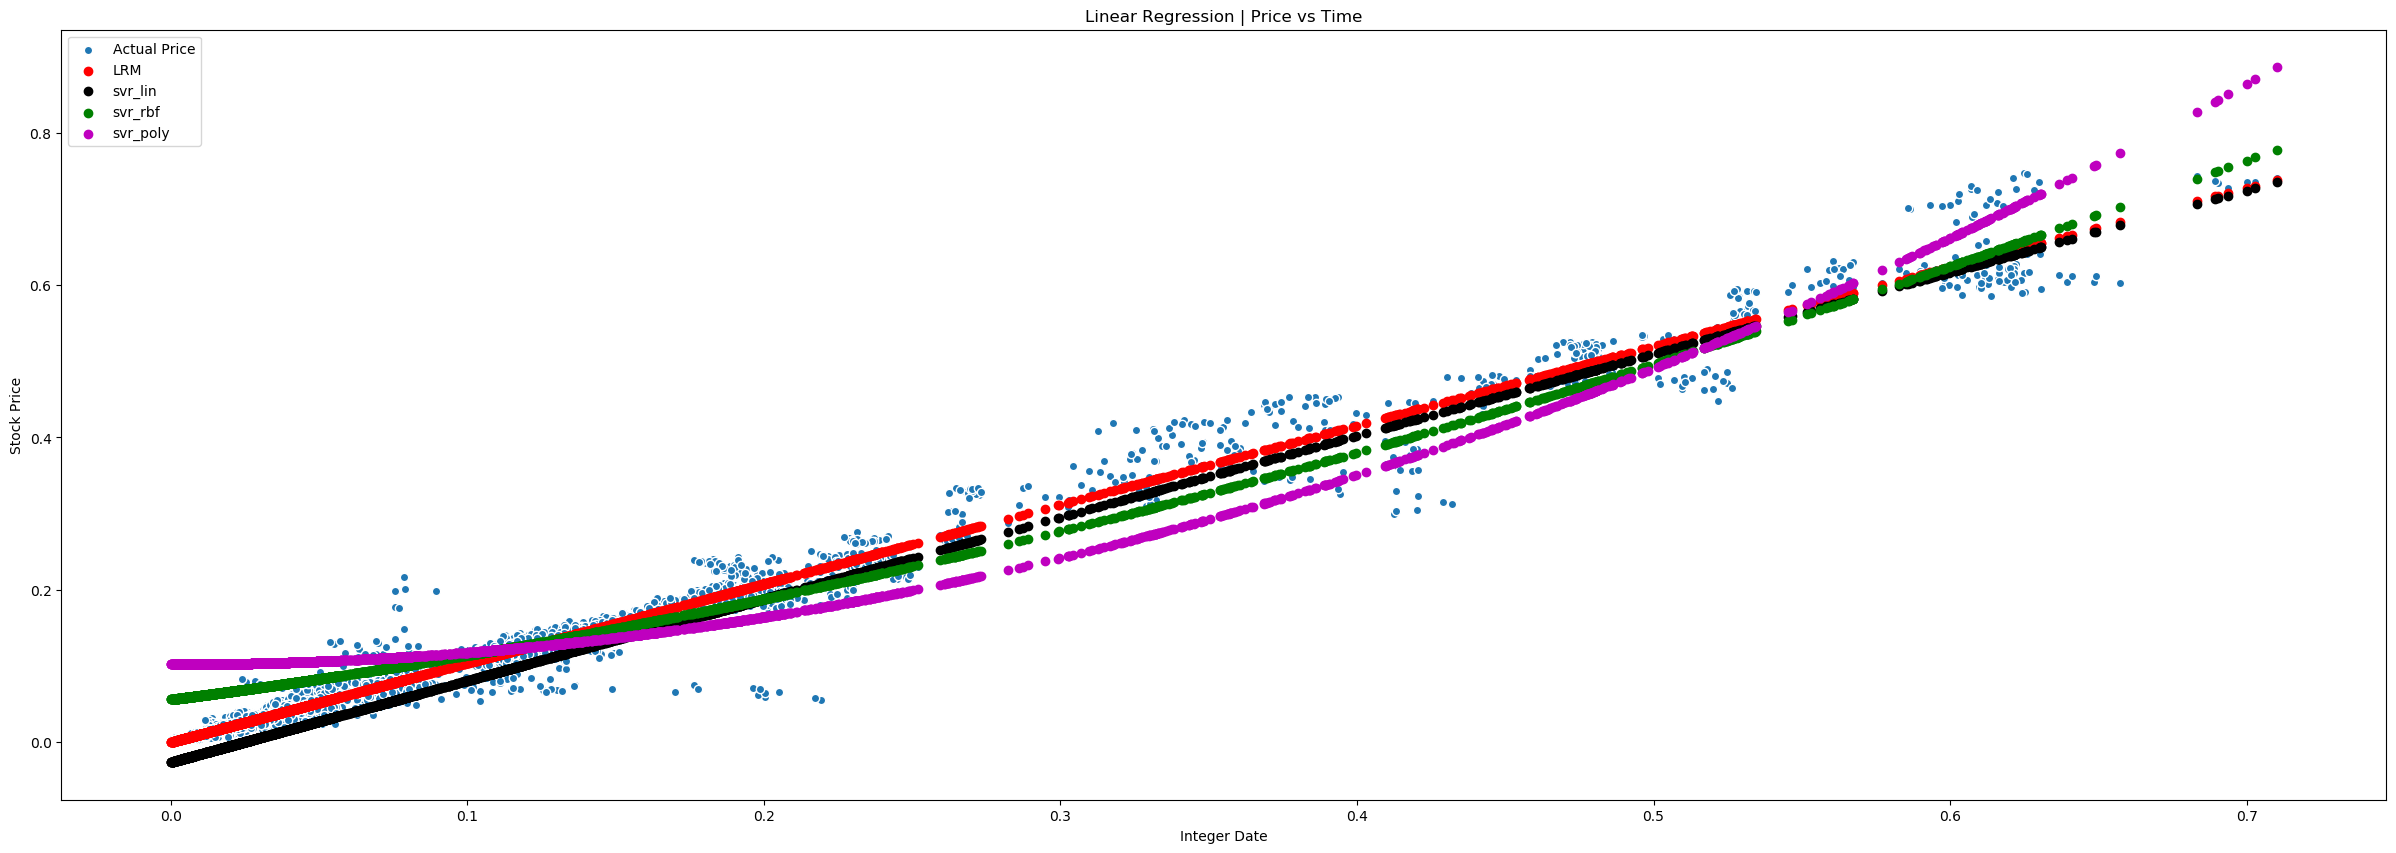

In [13]:
# Train set graph
plt.figure(1, figsize=(30,10))
plt.title('Linear Regression | Price vs Time')
plt.scatter(X_train, y_train, edgecolor='w', label='Actual Price')
plt.scatter(X_train, LRM.predict(X_train), color='r', label='LRM')
plt.scatter(X_train, svr_lin.predict(X_train), color='k', label='svr_lin')
plt.scatter(X_train, svr_rbf.predict(X_train), color='g', label='svr_rbf')
plt.scatter(X_train, svr_poly.predict(X_train), color='m', label='svr_poly')
plt.xlabel('Integer Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [14]:
# แสดงรูปกราฟเปรียบเทียบผลการ Predict validation และ Predict test ข้างต้นจากโมเดลทั้ง 4 

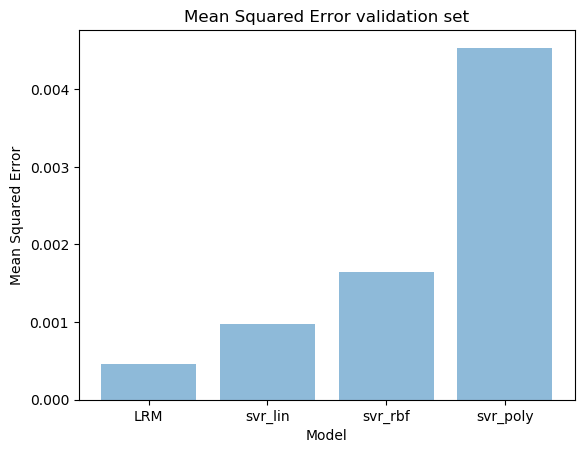

In [15]:
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_msr_valid, svr_lin_msr_valid, svr_rbf_msr_valid, svr_poly_msr_valid]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('Mean Squared Error validation set')

plt.show()

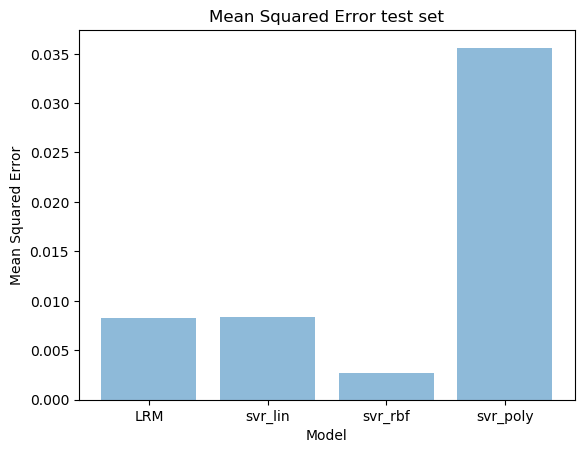

In [16]:
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_msr_test, svr_lin_msr_test, svr_rbf_msr_test, svr_poly_msr_test]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('Mean Squared Error test set')

plt.show()

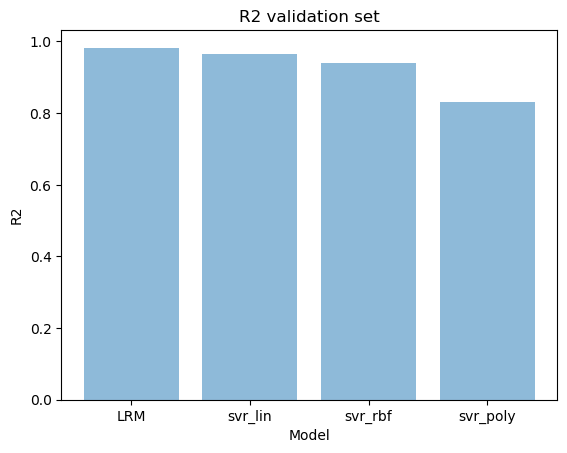

In [17]:
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_r2_valid, svr_lin_r2_valid, svr_rbf_r2_valid, svr_poly_r2_valid]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('R2')
plt.xlabel('Model')
plt.title('R2 validation set')

plt.show()

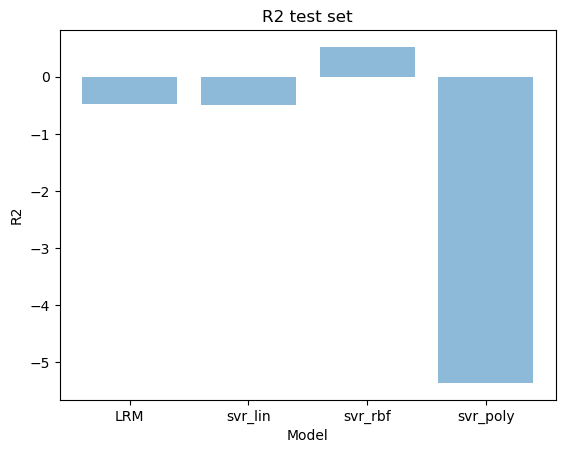

In [18]:
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly')
y_pos = np.arange(len(objects))
performance = [LRM_r2_test, svr_lin_r2_test, svr_rbf_r2_test, svr_poly_r2_test]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('R2')
plt.xlabel('Model')
plt.title('R2 test set')

plt.show()

# ตอนที่ 3: การทดลองการค้นหาพารามิเตอร์ที่ดีที่สุดสำหรับโมเดล

## 3.1 กำหนดรายการพารามิเตอร์ทั้งหมดที่ต้องการทดสอบหาค่าที่ดีที่สุดของโมเดล SVC

In [19]:
k_Fold = 10 # เลือก 10
c_param = [1, 10, 100, 300, 1000]          # เลือกค่า 2, 10, 100, 500
gamma = [1e-4, 1e-3, 0.01, 0.5, 1.0]               # เลือกค่า 0.3, 0.5, 1.0
svc_kernel = ('linear', 'rbf', 'poly')

tuned_parameters = {'kernel': svc_kernel, 'C': c_param, 'gamma': gamma}

## 3.2 เตรียมการค้นหาพารามิเตอร์ที่ดีที่สุดโดยใช้ฟังก์ชั่น GridSearchCV 

In [20]:
# กำหนดโมเดล
model = SVR()

# ใช้ cross validation (cv) เป็น kfold ที่กำหนดไว้ในตอนข้อ 2.1
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(model, tuned_parameters, cv=kf, scoring='r2')

# นำค่าพารามิเตอร์ที่ดีที่สุดที่ได้จาก GridSearchCV() ไปสอนโมเดล แสดงค่า score และพารามิเตอร์ที่ดีที่สุด fit() / best_params_/ best_score
clf.fit(X_train, y_train)
sorted(clf.cv_results_.keys())
best_score = clf.best_score_
best_params = clf.best_params_
print(best_params)

# save ผลลัพธ์จากการทำ GridSearchCV cv_results ลงบนไฟล์ .csv
best_param_df = pd.DataFrame(list(best_params.items()), columns=['Parameter', 'Cost'])
best_param_df.to_csv('cv_results.csv', index=False)

{'C': 300, 'gamma': 0.001, 'kernel': 'rbf'}


## 3.3 ทำการ predict ข้อมูลชุด Validation และ Test

In [21]:
cv_pred_valid = clf.predict(X_valid)
cv_pred_test  = clf.predict(X_test)

print('cv_pred_valid: ', cv_pred_valid)
print('cv_pred_test: ', cv_pred_test)

cv_pred_valid:  [-0.00444071  0.22443355  0.05053709 ...  0.01238287  0.02593302
 -0.00595479]
cv_pred_test:  [0.71924484 0.72611067 0.72131107 0.71899871 0.72753566 0.73833308
 0.75766071 0.76402763 0.76258326 0.74164289 0.75166944 0.74234242
 0.72394729 0.72888291 0.73586529 0.74068428 0.74211572 0.74659788
 0.74411067 0.74349535 0.75005665 0.75321746 0.7606272  0.75855455
 0.75223294 0.7503805  0.74623516 0.75167591 0.7552383  0.75772548
 0.74695412 0.7596103  0.76944887 0.77293996 0.78560233 0.79708578
 0.80086175 0.80191746 0.81639294 0.8348642  0.834644   0.82825812
 0.82717005 0.8279861  0.84918367 0.87199971 0.86874217 0.88197946
 0.8975867  0.90770852 0.92075073 0.92970656 0.88978313 0.91633429
 0.89407024 0.92400152 0.9071257  0.86418289 0.85674808 0.88734166]


## 3.4 คำนวณค่าตัววัดประสิทธิภาพของการทำนายที่ได้จากข้อ 3.5 โดยวัดค่า MSE และ R2

In [22]:
cv_msr_valid, cv_msr_test, cv_r2_valid, cv_r2_test = perfomance_measure('cv_pred_test', cv_pred_valid, cv_pred_test)

===  cv_pred_test  ===
Mean Squared Error LRM validation set: 0.0005017625627096218
Mean Squared Error LRM test set: 0.01053505782173205
R2 LRM validation set:  0.9812270733180275
R2 LRM test set:  -0.8827035060257793




## 3.5 แสดงรูปกราฟเปรียบเทียบผลการ Predict validation และ Predict test ข้างต้นจากโมเดลทั้ง 4 แบบ โดยในรูปแบบกราฟที่แสดงเห็นความแตกต่างชัดเจน เช่น กราฟ plot, bar, scatter เป็นต้น

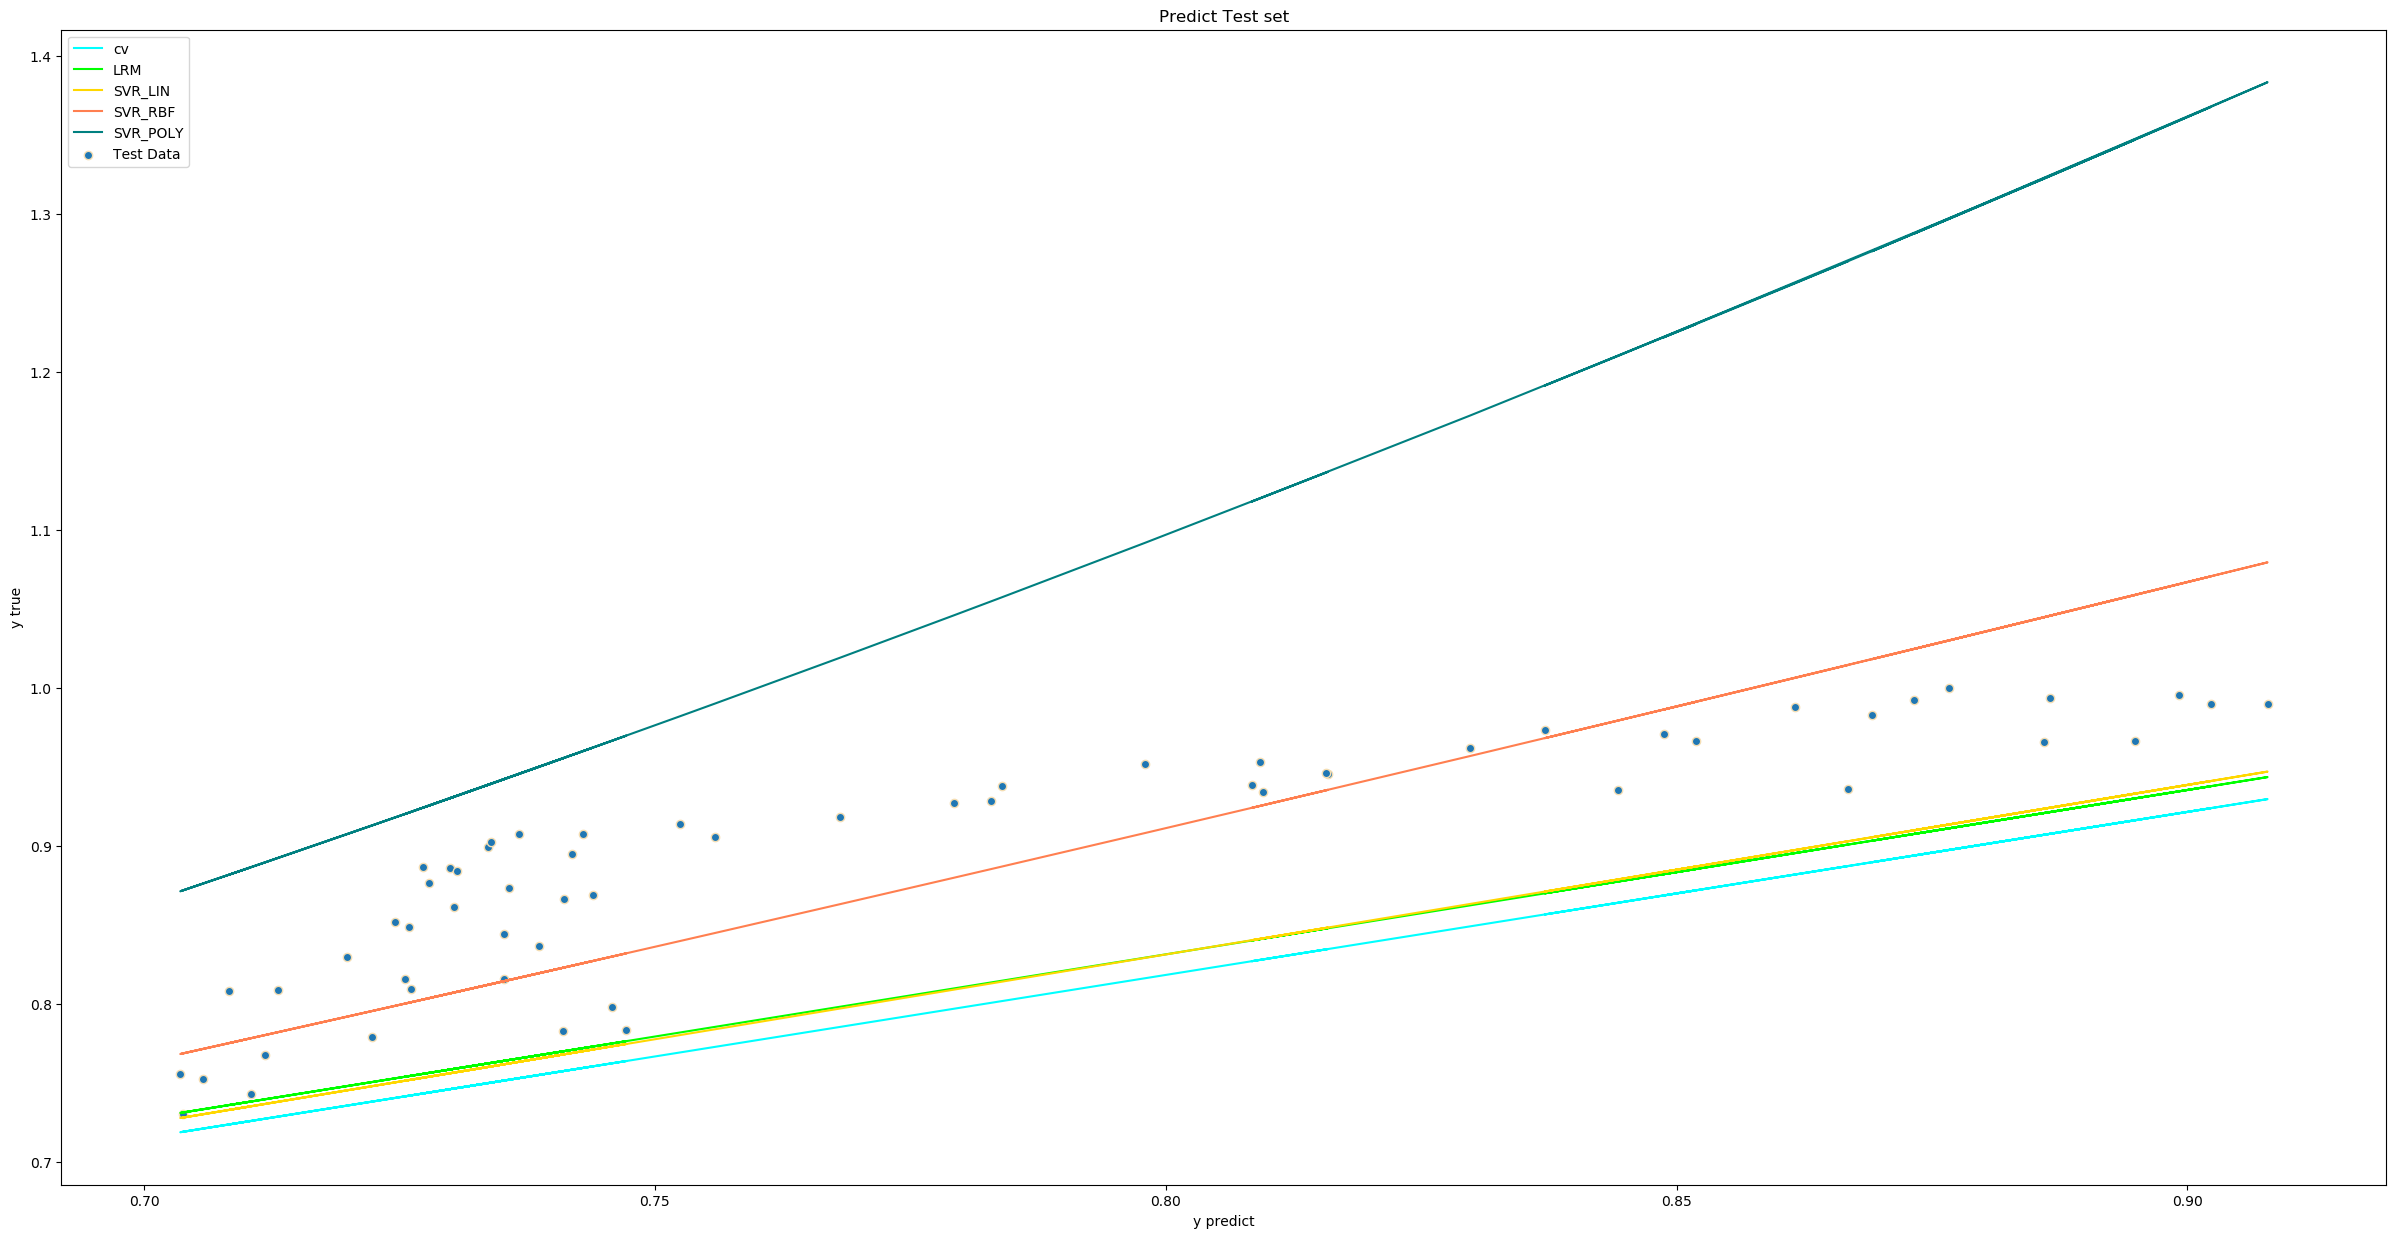

In [27]:
# Train set graph
plt.figure(1, figsize=(30,15))
plt.title('Predict Test set')
plt.scatter(X_test, y_test, edgecolor='wheat', label='Test Data')
plt.plot(X_test, cv_pred_test, color='cyan',label='cv')
plt.plot(X_test, LRM_pred_test, color='lime', label='LRM')
plt.plot(X_test, svr_lin_pred_test, color='gold', label='SVR_LIN')
plt.plot(X_test, svr_rbf_pred_test, color='coral', label='SVR_RBF')
plt.plot(X_test, svr_poly_pred_test, color='teal', label='SVR_POLY')

plt.xlabel('y predict')
plt.ylabel('y true')
plt.legend()
plt.show()

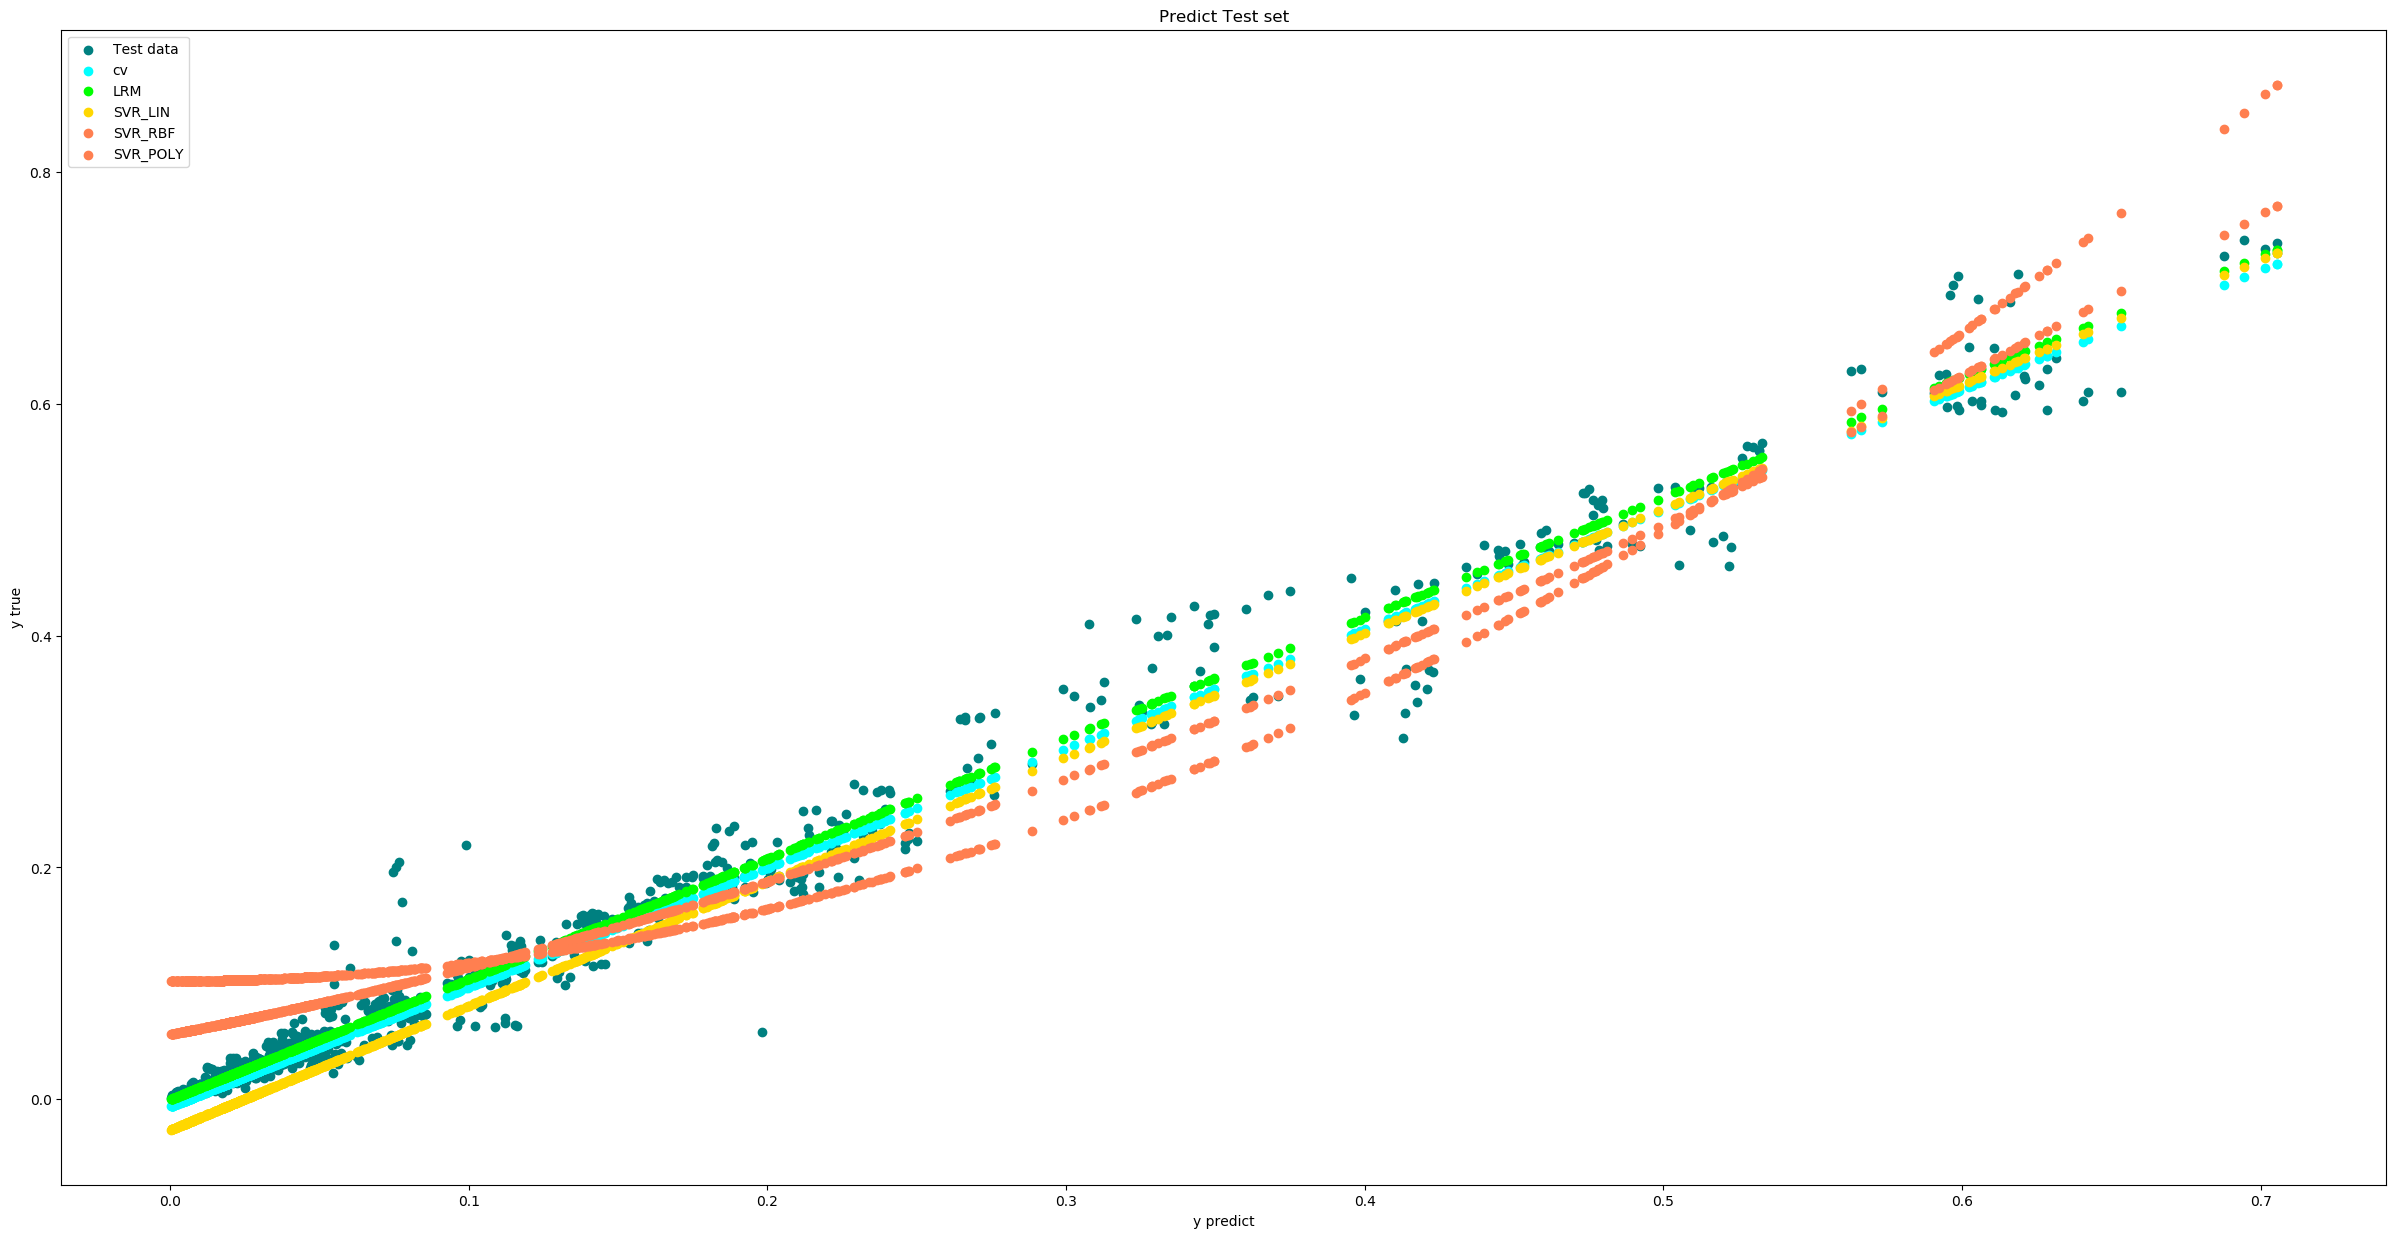

In [24]:
# Train set graph
plt.figure(1, figsize=(30,15))
plt.title('Predict Test set')
plt.scatter(X_valid, y_valid, color='teal', label='Test data')
plt.scatter(X_valid, cv_pred_valid, color='cyan',label='cv')
plt.scatter(X_valid, LRM_pred_valid, color='lime', label='LRM')
plt.scatter(X_valid, svr_lin_pred_valid, color='gold', label='SVR_LIN')
plt.scatter(X_valid, svr_rbf_pred_valid, color='coral', label='SVR_RBF')
plt.scatter(X_valid, svr_poly_pred_valid, color='coral', label='SVR_POLY')

plt.xlabel('y predict')
plt.ylabel('y true')
plt.legend()
plt.show()

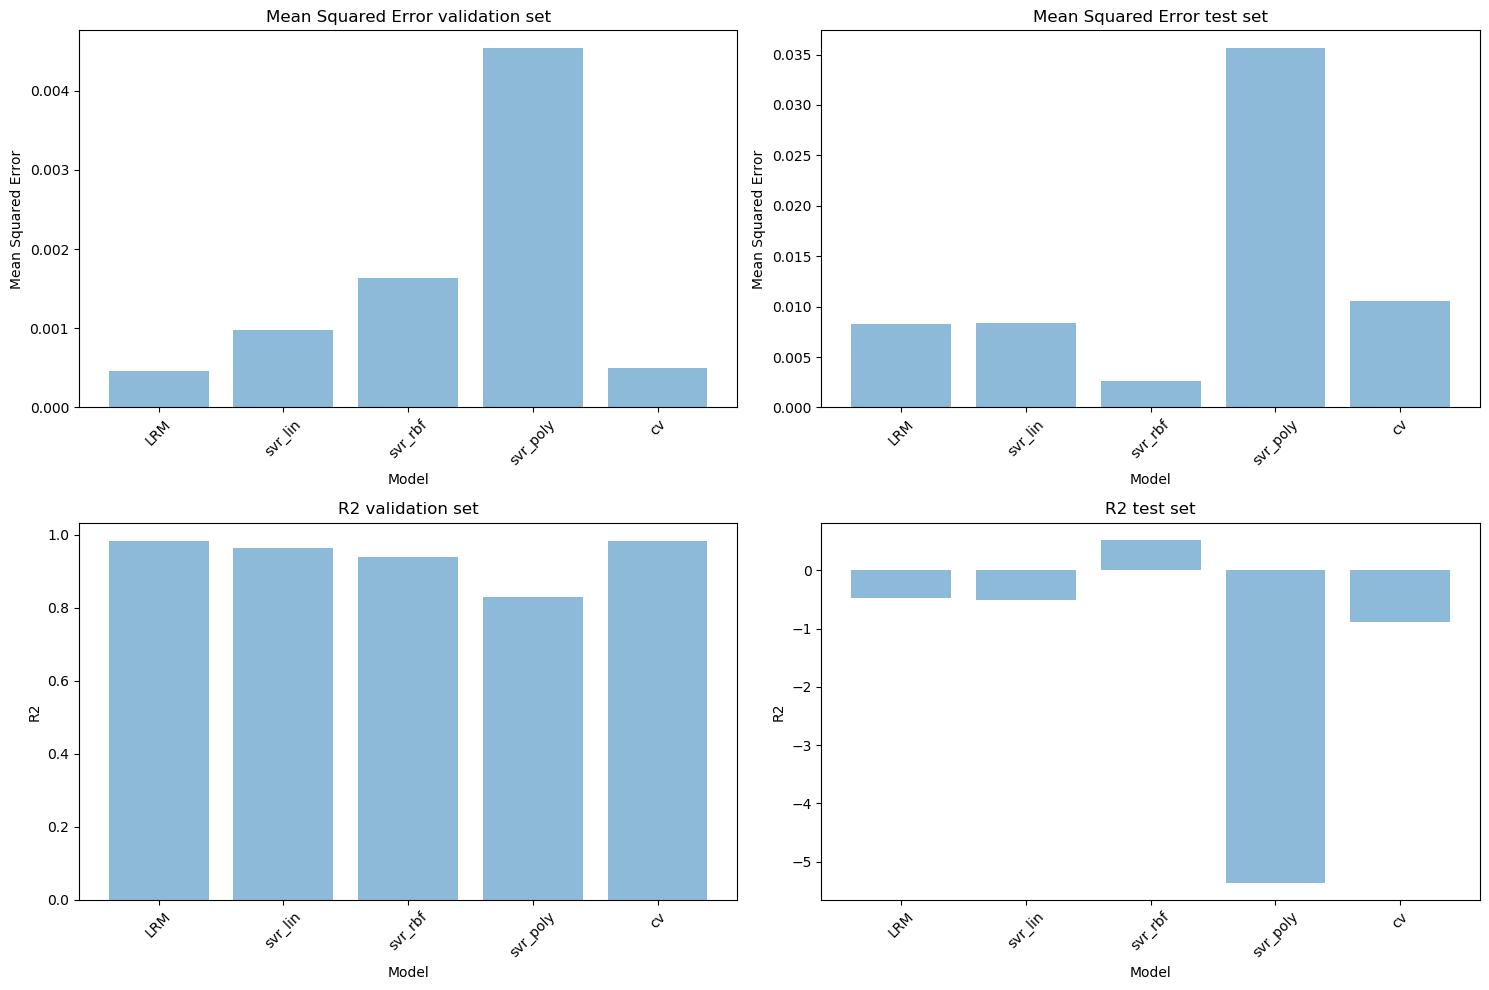

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))


# Use the pyplot interface to change just one subplot...
plt.sca(axes[0, 0])
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly', 'cv')
y_pos = np.arange(len(objects))
performance = [LRM_msr_valid, svr_lin_msr_valid, svr_rbf_msr_valid, svr_poly_msr_valid, cv_msr_valid]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('Mean Squared Error validation set')

plt.sca(axes[0, 1])
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly', 'cv')
y_pos = np.arange(len(objects))
performance = [LRM_msr_test, svr_lin_msr_test, svr_rbf_msr_test, svr_poly_msr_test, cv_msr_test]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('Mean Squared Error test set')

plt.sca(axes[1, 0])
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly', 'cv')
y_pos = np.arange(len(objects))
performance = [LRM_r2_valid, svr_lin_r2_valid, svr_rbf_r2_valid, svr_poly_r2_valid, cv_r2_valid]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('R2')
plt.xlabel('Model')
plt.title('R2 validation set')

plt.sca(axes[1, 1])
objects = ('LRM', 'svr_lin', 'svr_rbf', 'svr_poly', 'cv')
y_pos = np.arange(len(objects))
performance = [LRM_r2_test, svr_lin_r2_test, svr_rbf_r2_test, svr_poly_r2_test, cv_r2_test]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=45)
plt.ylabel('R2')
plt.xlabel('Model')
plt.title('R2 test set')


fig.tight_layout()
plt.show()